In [1]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import pandas as pd
import html 
import re

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
## Import Data

df_mots = pd.read_csv("./data/b_mot_cle.csv", encoding="utf8")
df_mots.info()
df_mot_entite = pd.read_csv("./data/num_mot_entite.csv", encoding="utf8")
df_mot_entite.info()
df_publis = pd.read_csv("./data/num_publis.csv", encoding="utf8")
df_publis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2542 non-null   int64 
 1   mot     2542 non-null   object
 2   valid   2542 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 59.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093 entries, 0 to 3092
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3093 non-null   int64  
 1   id_mot       3093 non-null   int64  
 2   id_publi     2234 non-null   float64
 3   id_ecriture  0 non-null      float64
 4   id_user      748 non-null    float64
 5   id_revue     76 non-null     float64
 6   id_numero    35 non-null     float64
 7   valid        3093 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 193.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data column

In [3]:
arti = df_publis.loc[:,["id","article"]]

In [4]:
arti.to_csv("num_articles.csv", index=False)

In [5]:
publis = df_publis.drop(columns="article")
publis.head()

,id,id_revue,id_numero,type,titre,soustitre,position,resume,id_ecriture_parent,slug,url,valid
0,239,1,35,0,Note de recherche-Le rôle de l’entrepreneuriat...,Sous titre par défaut,6,&lt;p style=&quot;text-align:justify; margin-b...,147,note-de-recherche-le-role-de-l-entrepreneuriat...,NaN,1
1,240,1,35,0,"Transformations organisationnelles, développem...",un cas d'adaptation au changement climatique,1,&lt;p&gt;&lt;strong&gt;R&amp;eacute;sum&amp;ea...,170,transformations-organisationnelles-developpeme...,NaN,1
2,241,1,35,0,Comment la digitalisation du don participatif ...,Sous titre par défaut,3,&lt;p&gt;La recomposition des &amp;eacute;cosy...,182,comment-la-digitalisation-du-don-participatif-...,NaN,1
3,242,1,35,0,La résilience urbaine inclusive,Les stratégies de résilience urbaine en direct...,2,&lt;p&gt;La tendance mondiale de l&amp;#39;urb...,243,la-resilience-urbaine-inclusive,NaN,1
4,243,1,35,0,La territorialisation comme condition de durab...,Sous titre par défaut,5,&lt;p&gt;R&amp;eacute;sum&amp;eacute;&lt;/p&gt...,251,la-territorialisation-comme-condition-de-durab...,NaN,1


In [6]:
publis.to_csv("publis_without_art.csv", index=False)

In [7]:
df_mots.head(20)

,id,mot,valid
0,1,systémique,1
1,2,data,1
2,4,FLE,1
3,6,plurilinguisme,1
4,7,enseignement bilingue,1
5,8,politique linguistique,1
6,9,acquisition,1
7,10,interaction,1
8,11,acquisition des langues étrangères,1
9,12,créolisation,1


In [8]:
# df_publis.set_index("id", inplace=True)
selection = df_mot_entite.id_mot == 6
publis = df_mot_entite[selection].id_publi.dropna().astype("int32").values
publis

array([  83,   84,   86,  172,  167,  229, 1540, 1542,   34, 1638])

In [9]:
print(df_publis.loc[publis].article)
df_publis.loc[publis].article.iloc[0]

83      &lt;blockquote&gt;\r\n&lt;p&gt;&amp;laquo;&amp...
84      &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
86      &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
172                                                   NaN
167     &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
229     &lt;h2&gt;&lt;strong&gt;1. Introduction&lt;/st...
1540    &lt;p class=&quot;texte&quot; dir=&quot;ltr&qu...
1542    &lt;h1 dir=&quot;ltr&quot; id=&quot;heading1&q...
34      &lt;div class=&quot;WordSection1&quot;&gt;\r\n...
1638    &lt;p class=&quot;texte&quot;&gt;Jean Birnbaum...
Name: article, dtype: object


'&lt;blockquote&gt;\r\n&lt;p&gt;&amp;laquo;&amp;nbsp;&amp;hellip;&lt;em&gt;Entre jeunes gens dont les sujets sont depuis longtemps construits dans le r&amp;eacute;seau signifiant d&amp;rsquo;une langue maternelle ou prise pour telle, l&amp;rsquo;apprentissage de la langue cible, ou langue du jeu, se fait dans le transfert subjectif... C&amp;rsquo;est &amp;agrave; la fois tr&amp;egrave;s grave et pleinement jouissif. L&amp;rsquo;acculturation passe par l&amp;rsquo;aventure d&amp;rsquo;un moi par les chemins, le contraire d&amp;rsquo;un enfermement&lt;/em&gt;&amp;nbsp;&amp;raquo;&lt;sup&gt;&lt;a href=&quot;#sdfootnote1sym&quot; name=&quot;sdfootnote1anc&quot;&gt;1&lt;/a&gt;&lt;/sup&gt;.&amp;nbsp;Robert LAFONT&lt;/p&gt;\r\n&lt;/blockquote&gt;\r\n\r\n&lt;p&gt;Deux pr&amp;eacute;occupations langagi&amp;egrave;res se croiseront dans cette r&amp;eacute;flexion en didactique des langues/cultures : celle de l&amp;rsquo;esth&amp;eacute;tique langagi&amp;egrave;re produite par la performance sc&a

In [12]:
# import re
# string = df_publis.loc[publis].article.iloc[0]
# cleantext = BeautifulSoup(string).text

# for match in re.finditer(".*plurilinguisme*.",cleantext):
#     print(match.span())
#     s = match.span()
    

In [35]:

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return html.unescape(cleantext)


data = list(df_publis.titre.dropna())
data = [cleanhtml(BeautifulSoup(string).text) for string in data]
print(len(data))
data
text

1815


0       Note de recherche-Le rôle de l’entrepreneuriat coopératif dans l’inclusion socioéconomique des femmes : Cas de la coopérative féminine des produits de la mer de Douira « COFEPROMER »Au niveau de la région Souss Massa, la collecte des ressources littorales essentiellement les moules, représente une des activités socioéconomiques de grande envergure. L’activité offre des revenus supplémentaires aux ménages locaux. Le nombre des femmes pratiquant cette activité varie d’un site à l’autre : Imessouane, Cap Ghir, Douira, Sidi Boulfdail... Cependant, une seule coopérative féminine COFEPROMER de Douira qui existe au niveau de la région qui assure la collecte et la valorisation des moules dans le Parc National de Souss Massa. La coopérative a comme vocation l'exploitation durable de cette ressource, l’assurance d’un revenu à même d’améliorer la situation des femmes du site Douira et la garantie de leur insertion socio-économique.\r\n\r\nL’objectif de notre article est de présenter le rô

In [32]:
df_publis["titre"] = df_publis.titre.apply(lambda x: cleanhtml(BeautifulSoup(x).text))
df_publis["resume"] = df_publis.resume.apply(lambda x: cleanhtml(BeautifulSoup(x).text) if x is not np.NaN else x)

df = df_publis.loc[:,["titre","resume"]].dropna()

text = df.titre + df.resume
print(len(text))
print(len(text.dropna()))

771
771


In [101]:
def create_embedding(data):
    model = SentenceTransformer('allenai-specter')
    embeddings = model.encode(data, show_progress_bar=True)
    return embeddings

from sklearn.cluster import SpectralClustering, KMeans

def create_clusters(data, embeddings):

    umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

#     cluster = SpectralClustering(n_clusters=30, eigen_solver=None, n_components=None).fit(umap_embeddings)
#     cluster = KMeans(n_clusters=50).fit(embeddings)

    
    umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    return result, cluster

def plot_clusters(result_df):
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result_df.loc[result.labels == -1, :]
    clustered = result_df.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#0a0909', s=5)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
    plt.colorbar()
    

In [36]:
data = list(text)
embeddings = create_embedding(data)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [37]:
len(embeddings[0])

768

In [102]:
result, cluster = create_clusters(data, embeddings)

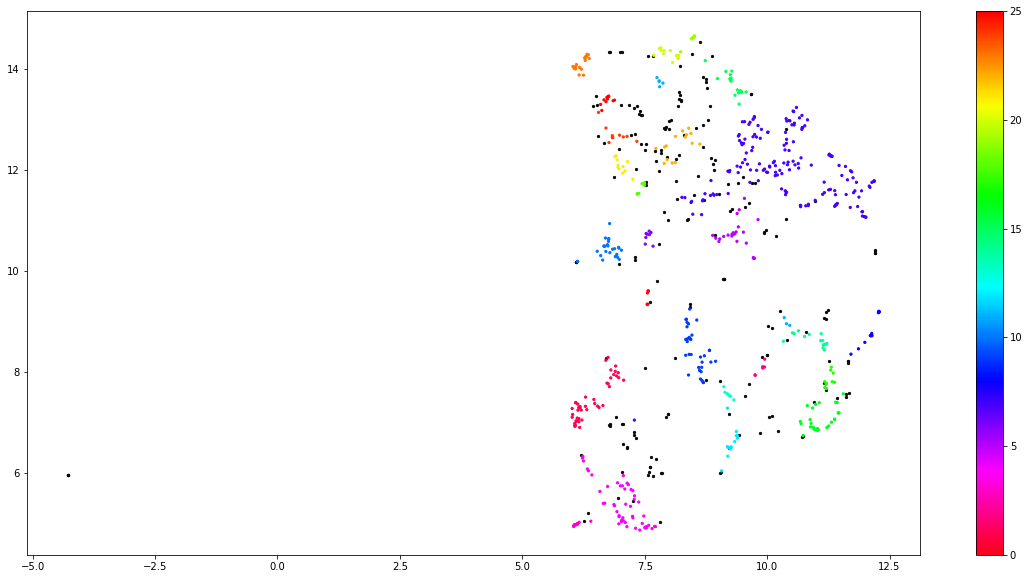

In [103]:
plot_clusters(result)

In [104]:
import stopwords

def lemma():
    pass

STOP_WORDS = set(stopwords.STOP_WORDS_FR.extend([stopwords.STOP_WORDS_EN,stopwords.STOP_WORDS_IT, stopwords.STOP_WORDS_ES]))

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.STOP_WORDS_FR, strip_accents='unicode').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def get_n_topwords(data, cluster):
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    return top_n_words, docs_df
    

top_n, docs_df = get_n_topwords(data,cluster)

AttributeError: 'set' object has no attribute 'extend'

In [42]:
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame({"titre":data,"cluster":cluster.labels_})
select = results.cluster == 8
results[select]

titre  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Note de recherche-Le rôle de l’entrepreneuriat coopératif dans l’inclusion socioéconomique des femmes : Cas de la coopérative féminine des produits de la mer de Douira « COFEPROMER »Au niveau de la région Souss Massa, la collecte des ressources littorales essentiellement les moules, représente une des activités socioéconomiques de grande envergure. L’activité offre des revenus supplémentaires aux ménages locaux. Le nombre des femmes pratiquant cette activité varie d’un site à l’autre : Imessouane, Cap Ghir, Douira, Sidi Boulfdail... Cependant, une seule coopérative féminine COFEPROMER de Douira qui existe au niveau de la région qui assure la collecte et la valorisation des moules dans le Parc National de Souss Massa. La coopérative a comme vocation l'exploitation durable de cette ressource, l’assurance d’un revenu à même d’améliorer la situation des femmes du site Douira et la garantie de leur insertion socio-économique.\r\n\r\nL’objectif de notre article est de présenter le rôle du modèle coopératif marocain dans l’inclusion socio-économique des femmes dans le secteur de pêche, un secteur qui reste masculin et qui soulève la problématique du genre, en se basant sur une étude de cas au sein d’une coopérative féminine des produits de la mer de Douira « COFEPROMER ». Notre démarche est exploratoire basée sur un guide d’entretien administré à la responsable et les femmes membres de la coopérative pour cerner la perception des impacts socio-économiques. \r\n\r\n Les résultats obtenus à travers la présente étude montrent l’importance socio-économique des activités littorales compte tenu de sa contribution comme source de revenus supplémentaires aux familles autochtones. En effet, la présence des coopératives au niveau des zones d’exploitation pourrait aider à la diffusion de l’information, à la sensibilisation des exploitantes vis-à-vis de la préservation de la ressource et à l’amélioration de la qualité des produits transformés.\r\n\r\n \r\n\r\nIn the Souss Massa region, the collection of coastal resources, mainly mussels, represents one of the major socio-economic activities. The number of women practicing this activity varies from one site to another: Imessouane, Cap Ghir, Douira, Sidi Boulfdail ... However, only one female cooperative COFEPROMER in Douira provides the collection and the enhancement of mussels in the Souss Massa National Park. The purpose of the cooperative is to ensure the sustainable exploitation of this resource, the improvement of women’s life conditions and their socio-economic integration.\r\n\r\nThe aim of this article is to present the role of the Moroccan cooperative model in the socio-economic inclusion of women in the fishing sector, a sector which remains male oriented, based on a case study within a female cooperative. Our approach is exploratory based on an interview administered to the manager and th

In [100]:
print(len(top_n))
top_n[28][:10]

35


[('traumatisme', 0.03520538663355588),
 ('conversions', 0.032437255611007056),
 ('arts', 0.03025289076930813),
 ('otto', 0.02490600715949557),
 ('miedo', 0.02384970632487209),
 ('visuels', 0.02384970632487209),
 ('stylistiques', 0.02384970632487209),
 ('guerre', 0.02359441447817522),
 ('carlos', 0.022986645700995383),
 ('martin', 0.022986645700995383)]

In [19]:
# Néttoyer les langues
# Lemmatisation


In [67]:
# Visualize with plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def _plotly_topic_visualization(df: pd.DataFrame,
                                    topic_list: list):
        """ Create plotly-based visualization of topics with a slider for topic selection """

        def get_color(topic_selected):
            if topic_selected == -1:
                marker_color = ["#B0BEC5" for _ in topic_list[1:]]
            else:
                marker_color = ["red" if topic == topic_selected else "#B0BEC5" for topic in topic_list[1:]]
            return [{'marker.color': [marker_color]}]

        # Prepare figure range
        x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
        y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

        # Plot topics
        fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                         hover_data={"x": False, "y": False, "Topic": True, "Words": True, "Size": True})
        fig.update_traces(marker=dict(color="#B0BEC5", line=dict(width=2, color='DarkSlateGrey')))

        # Update hover order
        fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[2]}</b>",
                                                     "Words: %{customdata[3]}",
                                                     "Size: %{customdata[4]}"]))

        # Create a slider for topic selection
        steps = [dict(label=f"Topic {topic}", method="update", args=get_color(topic)) for topic in topic_list[1:]]
        sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

        # Stylize layout
        fig.update_layout(
            title={
                'text': "<b>Intertopic Distance Map",
                'y': .95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(
                    size=22,
                    color="Black")
            },
            width=650,
            height=650,
            hoverlabel=dict(
                bgcolor="white",
                font_size=16,
                font_family="Rockwell"
            ),
            xaxis={"visible": False},
            yaxis={"visible": False},
            sliders=sliders
        )

        # Update axes ranges
        fig.update_xaxes(range=x_range)
        fig.update_yaxes(range=y_range)

        # Add grid in a 'plus' shape
        fig.add_shape(type="line",
                      x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                      line=dict(color="#CFD8DC", width=2))
        fig.add_shape(type="line",
                      x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                      line=dict(color="#9E9E9E", width=2))
        fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
        fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
        fig.data = fig.data[::-1]

        return fig
    
frequencies = extract_topic_sizes(docs_df)

In [73]:
all_words = []
for i in top_n:
    top = top_n[i]
    words = []
    for t in top:
        words.append(t[0])
    all_words.append(words)


In [83]:
print(len(all_words),len(umap_data),len(frequencies),len(cluster.labels_))

35 771 35 771


In [75]:

df = pd.DataFrame({"x": umap_data[:,0], "y": umap_data[:, 1],
                   "Topic": cluster.labels_ , "Words": all_words , "Size": frequencies})

_plotly_topic_visualization(df)

ValueError: arrays must all be same length

In [ ]:
# from bertopic import BERTopic

# topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")
# topics, _ = topic_model.fit_transform(data)
# topic_model.get_topic_freq().head()

In [85]:
from bertopic import BERTopic

cluster_model= hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='manhattan',                      
                          cluster_selection_method='eom')
topic_model = BERTopic(
        hdbscan_model= cluster_model
)
topics, _ = topic_model.fit_transform(data, embeddings)
topic_model.get_topic_freq().head()

,Topic,Count
0,-1,236
1,19,49
2,11,43
3,0,40
4,20,29


In [86]:
topic_model.visualize_topics()

In [23]:
# def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
#     words = count.get_feature_names()
#     labels = list(docs_per_topic.Topic)
#     tf_idf_transposed = tf_idf.T
#     indices = tf_idf_transposed.argsort()[:, -n:]
#     top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
#     return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

# top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,481
45,44,43
33,32,41
82,81,40
85,84,38
71,70,37
27,26,37
18,17,31
30,29,30
26,25,30
